This section imports necessary libraries for data manipulation, analysis, visualization, and option pricing:

- `datetime`: This module provides functions to work with dates and times.
- `pandas`: Pandas is a powerful library for data manipulation and analysis, particularly for handling tabular data.
- `numpy`: Numpy is a fundamental package for scientific computing with Python, enabling numerical operations on arrays and matrices.
- `yfinance`: YFinance is a Python library to fetch historical market data from Yahoo Finance.
- `matplotlib.pyplot`: Matplotlib is a plotting library for Python. The pyplot module provides a MATLAB-like interface for creating plots and visualizations.
- `py_vollib`: Py_vollib is a Python library for calculating option prices, implied volatility, and option Greeks using the Black-Scholes model.


In [1]:
# Importing libraries
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

This segment fetches historical stock data for the 'SPY' ticker from Yahoo Finance:

- `end`: Represents the current date and time.
- `start`: Specifies January 1, 2020, as the start date for historical data retrieval.
- `df`: Refers to the DataFrame containing historical stock data fetched using the `yf.download` function.
- `Close`: Extracts the closing prices from the DataFrame.
- `Close.tail()`: Displays the last few rows of the closing prices DataFrame.


In [2]:
#Importing ticker Data
end = dt.datetime.now()
start = dt.datetime(2020,1,1)
df = yf.download('SPY', start=start, end=end)
Close = df.Close
Close.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2024-10-23    577.989990
2024-10-24    579.239990
2024-10-25    579.039978
2024-10-28    580.830017
2024-10-29    581.770020
Name: Close, dtype: float64

This section calculates historical returns and volatility of the stock:

- `og_returns`: Computes the daily log returns of the stock using the formula: log returns = ln(Pt / Pt−1), where Pt is the price at time t.
  
- `TRADING_DAYS`: Specifies the number of trading days for calculating rolling volatility.
  
- `volatility`: Calculates rolling volatility using a window of 20 trading days and annualizes it by multiplying by the square root of 252 (the number of trading days in a year).
  
- `volatility.plot()`: Plots the volatility over time.
  
- `volatility.iloc[-1], Close.iloc[-1]`: Prints the last calculated volatility value and the most recent closing price.


(0.0878268981210268, 581.77001953125)

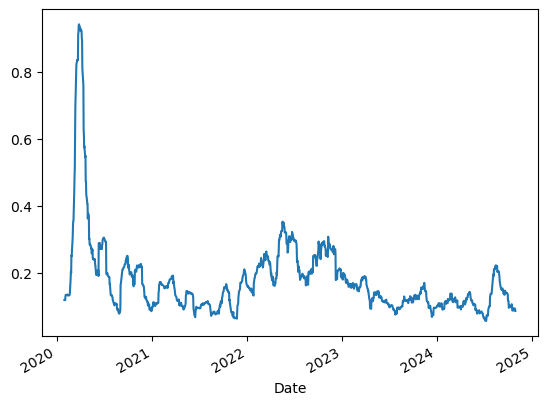

In [3]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility.plot()
volatility.iloc[-1], Close.iloc[-1]

Mathematically, implied volatility is calculated using the Black-Scholes model. The Black-Scholes formula for European call and put options is given by:

For a European call option:
\[ C(S,K,T,r,\sigma) = S_0 N(d_1) - Ke^{-rT} N(d_2) \]

For a European put option:
\[ P(S,K,T,r,\sigma) = Ke^{-rT} N(-d_2) - S_0 N(-d_1) \]

Where:
- \( S_0 ) = Current stock price
- \( K \) = Strike price
- \( T \) = Time to maturity (in years)
- \( r \) = Risk-free interest rate
- \( \sigma \) = Implied volatility
- \( N() \) = Cumulative distribution function of the standard normal distribution
- \( d_1 = \frac{{\ln(S_0 / K) + (r + \frac{{\sigma^2}}{2})T}}{{\sigma \sqrt{T}}} \)
- \( d_2 = d_1 - \sigma \sqrt{T} \)

The implied volatility is the value of \( \sigma \) that makes the option price calculated using the Black-Scholes formula equal to the observed market price. It is essentially solving for \( \sigma \) in the Black-Scholes equation given the other parameters and the observed market price of the option.


In [4]:
def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    max_iter = 200 #max no. of iterations
    vol_old = 0.1 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price

        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break

        vol_old = vol_new

    implied_vol = vol_new
    return implied_vol

References:
•	Black, Fischer, and Myron Scholes. "The pricing of options and corporate liabilities." Journal of political economy 81.3 (1973): 637-654.
•	Hull, John C. "Options, futures, and other derivatives." Pearson Education India, 2017.

This function calculates the implied volatility of an option using the Black-Scholes model:

- `S0`: Represents the current stock price.
  
- `K`: Denotes the strike price of the option.
  
- `T`: Indicates the time to maturity of the option.
  
- `r`: Represents the risk-free interest rate.
  
- `market_price`: Refers to the observed market price of the option.
  
- `flag`: Specifies the type of option ('c' for call, 'p' for put).
  
- `tol`: Represents the tolerance level for convergence in the iterative method.

The function iteratively refines the volatility estimate until the difference between the theoretical option price and the market price is within the tolerance level or until the maximum number of iterations is reached.

This section calculates the implied volatility for call and put options with ATM (At-The-Money) strikes and different bid and ask prices:

- `S0`: Represents the current stock price.

- `atm_options`: A list containing ATM options, where each option is represented by its expiration date, strike price, call bid/ask prices, and put bid/ask prices.

- `call_bids`, `call_asks`, `put_bids`, `put_asks`: Lists to store the implied volatilities for call and put options.

- `IV_DTE`: List to store the days to expiration (DTE) for each option.

The loop iterates over each ATM option, calculates the time to maturity (T) in years, and then computes the implied volatility using the `implied_vol` function defined earlier.

In [5]:
S0 = 102
atm_options = [[dt.date(2021,10,18),102,[2.585,3.25],[4.600,5.300]],]
call_bids,call_asks,put_bids,put_asks, = [],[],[],[]
IV_DTE = []

for i in atm_options:
    date, K = i[0], i[1]
    DTE = (date - dt.date(2021,7,30)).days
    T = DTE/365
    r = 0.02
    call_bid, call_ask = i[2]
    put_bid, put_ask = i[3]

    call_bids.append(implied_vol(S0, K, T, r, call_bid, flag='c')*100)
    call_asks.append(implied_vol(S0, K, T, r, call_ask, flag='c')*100)
    put_bids.append(implied_vol(S0, K, T, r, put_bid, flag='p')*100)
    put_asks.append(implied_vol(S0, K, T, r, put_ask, flag='p')*100)
    IV_DTE.append(DTE)

call_bids,call_asks,put_bids,put_asks

([12.391744243113061],
 [15.89983054184741],
 [25.370308271406177],
 [29.062481076021502])

This section sets the parameters for the delta hedging simulation:

- `K`: Represents the strike price of the option.
  
- `N`: Specifies the number of time steps in the simulation.
  
- `sigma`: Denotes the volatility of the underlying stock.
  
- `S0`: Indicates the current stock price.
  
- `DTE`: Refers to the days to expiration of the option.
  
- `T`: Represents the time to maturity of the option in years.
  
- `r`: Specifies the risk-free interest rate.
  
- `DT`: Represents the time increment for each step in the simulation.
  
- `TTE`: Indicates the time to expiration at each step in the simulation.

These parameters are used to simulate stock price movements over time and perform dynamic delta hedging.


In [6]:
K = 105
N = 11 # 11 weeks
sigma = 0.30
S0 = 102
DTE = (dt.date(2021,10,18) - dt.date(2021,7,30)).days
T = DTE/365
r = 0.02
DT = T/N
TTE = [DT*N-DT*i for i in range(0,N+1)]

These helper functions are used in the dynamic delta hedging simulation:

- `calc_delta`: Calculates the delta of the option based on the Black-Scholes model. It takes into account whether the position is long or short.

- `adjust`: Determines the adjustment action (buy, sell, or none) based on the calculated delta and total position.

- `totalAdj`: Determines the total adjustment action (long or short) based on the total delta position.

- `cashAdj`: Calculates the cash adjustment needed based on the delta, price, time, and total position.


In [7]:
def calc_delta(flag, price, K, time, r, sigma, position='s'):
    if time == 0:
        return np.nan
    else:
        if position=='l':
            return int(delta(flag, price, K, time, r, sigma)*100)
        else:
            return -int(delta(flag, price, K, time, r, sigma)*100)

def adjust(delta, total):
    if delta < 0:
        return 'Buy {0}'.format(abs(delta))
    elif delta > 0:
        return 'Sell {0}'.format(abs(delta))
    elif delta == 0:
        return 'None'
    else:
        if total < 0:
            return 'Sell {0}'.format(abs(total))
        elif total > 0:
            return 'Buy {0}'.format(abs(total))
        else:
            return np.nan

def totalAdj(counter,time):
    if time > 0:
        if counter < 0:
            return 'Long {0}'.format(abs(counter))
        elif counter > 0:
            return 'Short {0}'.format(abs(counter))
        else:
            return np.nan
    else:
            return np.nan

def cashAdj(delta, price, time, total):
    if time > 0:
        return delta*price
    else:
        return -total*price

This section initializes a DataFrame to store the results of the dynamic delta hedging simulation:

- `Dynamic_Hedging_Results`: DataFrame to store various metrics related to delta hedging, such as option P&L, stock P&L, adjustment P&L, carry on options, carry on stock, and interest on adjustments.
  
- The index of the DataFrame is set to different metrics, and the name of the DataFrame is set to 'Dynamic hedging results'.

Additionally, the bid and ask prices for call and put options are defined.


In [8]:
Dynamic_Hedging_Results = pd.DataFrame(data=[], columns=[],
                            index=['Original Option P&L','Original Stock P&L',
                            'Adjustment P&L','Carry (interest) on options',
                                   'Carry (interest) on stock',
                                   'Interest on Adjustments'])
Dynamic_Hedging_Results.index.name = 'Dynamic hedging results'

call_bid,call_ask,put_bid,put_ask = 2.585,3.25,4.600,5.300

# number of sims
M = 1000

# Realized Volatility
sigma = 0.12

# Position in Option contract
k = 102
position = 's'
flag = 'c'

This segment simulates stock price movements over time using geometric Brownian motion:

- `St`: Represents the initial current stock price.

- `St_series`: A list to store simulated stock price series.

The loop iterates over each time step (N) to generate the stock price at each step based on the geometric Brownian motion formula:

\[ St = S_0 \c *e^{(r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t} \cdot Z_t} \]

where \( Z_t \) is a standard normal random variable.

The resulting stock price series are stored in the DataFrame `df`, where each column represents a simulation, and each row represents a time step.

This simulation provides the basis for dynamic delta hedging, where the option's delta is adjusted according to the simulated stock price movements.


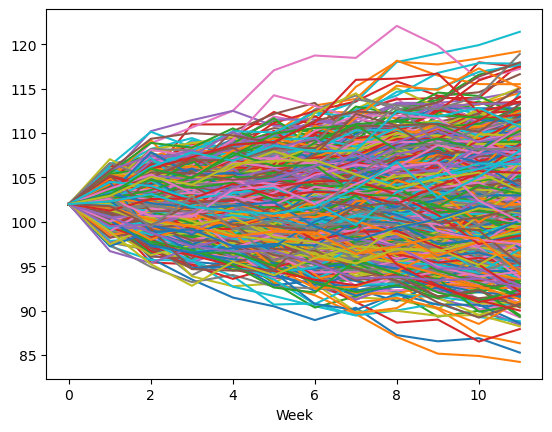

,Time,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
Week,,,,,,,,,,,,,,,,,,,,,
0,0.22,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,...,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
1,0.20,101.84,100.73,101.84,102.31,101.86,100.67,101.33,100.61,102.83,...,103.19,101.66,103.07,101.27,99.51,101.76,102.62,102.86,102.92,102.31
2,0.18,101.26,100.31,103.90,102.89,103.84,102.37,98.21,101.29,99.89,...,102.11,100.25,105.99,102.57,99.66,99.58,100.65,99.46,105.05,103.11
3,0.16,100.82,100.06,104.75,104.08,100.35,104.44,100.89,100.68,96.17,...,101.60,99.48,104.94,102.62,101.12,102.10,100.57,102.88,104.18,101.70
4,0.14,101.62,101.38,104.43,105.66,101.33,104.16,101.56,102.13,97.48,...,101.80,98.36,107.76,104.27,103.87,102.60,103.63,99.19,106.52,101.17
5,0.12,99.46,100.97,104.53,104.43,100.87,101.04,105.36,101.62,96.53,...,102.20,98.91,106.30,102.92,104.89,100.87,104.04,100.15,106.86,100.93
6,0.10,99.68,102.96,104.64,103.42,102.13,101.00,107.51,101.98,98.35,...,99.49,98.80,106.37,103.38,106.29,102.65,102.02,100.91,106.96,101.68
7,0.08,101.21,99.67,101.83,100.03,101.99,97.89,107.73,102.92,98.93,...,97.92,96.40,103.08,103.20,107.52,101.70,104.27,105.15,105.34,103.76
8,0.06,100.96,100.66,101.50,99.90,103.27,97.18,106.40,99.66,98.52,...,99.36,97.24,102.92,102.02,105.42,102.24,106.15,108.20,103.79,106.74


In [9]:
nudt = (r - 0.5*sigma**2) * DT
sigmasdt = sigma*np.sqrt(DT)

no_hedge = []
static_hedge = []

# number of sims

St = S0
St_series = [np.array([St for m in range(M)])]
for i in range(N):
    St = St_series[-1]
    Stn = np.round( St * np.exp(nudt + sigmasdt*np.random.normal(0,1,M)) , 2)
    St_series.append(Stn)

St_series = np.array(St_series)

df = pd.DataFrame(St_series, columns = [i for i in range(M)])
df.index.name = 'Week'
df.plot()
plt.legend().set_visible(False)
plt.show()
df.insert(0, "Time", np.round(TTE,2))
df

This section performs the dynamic delta hedging simulation:

- `hedgeSim`: DataFrame containing simulated stock prices for a particular simulation.

- `Delta`: Calculates the delta for each simulated stock price using the `calc_delta` function.

- `Total Delta Position`: Computes the change in delta position for each time step.

- `Total Adjustment`: Determines the total adjustment action (long or short) for each time step.

- `Adjustment Action` and `Adjustment Cashflow`: Determine the adjustment action (buy or sell) and cash flow needed for delta hedging at each time step.

- `Interest on Adjustments`: Calculates the interest accrued on adjustments.

- P&L components for the option and the stock are computed based on the simulated prices and delta hedging strategy.

- Results are stored in the `Dynamic_Hedging_Results` DataFrame.

- The P&L for no hedging and static hedging is also calculated and stored in the lists `no_hedge` and `static_hedge`.

- Summary statistics are calculated and added to the DataFrame.


In [11]:
import warnings
from pandas.errors import PerformanceWarning

# Use a context manager to ignore the warning only within this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore", PerformanceWarning)

    for sim in range(M):
        hedgeSim = df.loc[:,['Time',sim]]
        hedgeSim.columns = ['Time', 'Price']

        # hedge calcs
        hedgeSim['delta'] = hedgeSim.apply(lambda x: calc_delta(flag, x['Price'],
                                            K, x['Time'], r, sigma, position), axis=1)
        hedgeSim['Total Delta Position'] = (hedgeSim.delta - hedgeSim.delta.shift(1))
        totaladjust_c = [hedgeSim['Total Delta Position'][:i].sum() for i in range(1,N+1)]
        hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum()
                                     for i in range(1,N+2)]
        hedgeSim['Adjustment Contracts'] = hedgeSim.apply(
            lambda x: adjust(x['Total Delta Position'], x['totaladjust_c']), axis=1)
        hedgeSim['Total Adjustment'] = hedgeSim.apply(lambda x: totalAdj(x['totaladjust_c'],
                                                                x['Time']),axis=1)
        hedgeSim['totaladjust_c'] = [hedgeSim['Total Delta Position'][:i].sum()
                                     for i in range(1,N+2)]
        hedgeSim['Adjustment Cashflow'] = hedgeSim.apply(
            lambda x: cashAdj(x['Total Delta Position'],
                                            x['Price'],x['Time'], x['totaladjust_c']), axis=1)
        hedgeSim['Interest on Adjustments'] = hedgeSim.apply(
            lambda x: round(x['Adjustment Cashflow']*r*x['Time'],2),
                                                             axis=1)
        hedgeSim = hedgeSim.drop(columns=['totaladjust_c'])

        # calculate payoffs
        if flag == 'c':
            if position == 's':
                optprice = call_bid
                option_pnl = 100*(optprice - np.maximum(hedgeSim.loc[11,'Price']-K,0))
                # delta will be negative if short
                stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
                adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
                option_carry = 100*optprice*r*T
                # delta will be negative if short
                stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
                int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
            else:
                optprice = call_ask
                option_pnl = 100*(np.maximum(hedgeSim.loc[11,'Price']-K,0) - optprice)
                # delta will be positive if long
                stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
                adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
                option_carry = -100*optprice*r*T
                # delta will be positive if long
                stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
                int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

        elif flag == 'p':
            if position == 's':
                optprice = put_bid
                option_pnl = 100*(optprice - np.maximum(K-hedgeSim.loc[11,'Price'],0))
                # delta will be positive if short
                stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
                adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
                option_carry = 100*optprice*r*T
                # delta will be positive if short
                stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
                int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()
            else:
                optprice = put_ask
                option_pnl = 100*(np.maximum(K-hedgeSim.loc[11,'Price'],0) - optprice)
                # delta will be negative if long
                stock_pnl = hedgeSim.loc[0,'delta']*(S0 - hedgeSim.loc[11,'Price'])
                adj_pnl = hedgeSim['Adjustment Cashflow'].sum()
                option_carry = -100*optprice*r*T
                # delta will be negative if long
                stock_carry = hedgeSim.loc[0,'delta']*S0*r*T
                int_adj_pnl = hedgeSim['Interest on Adjustments'].sum()

        data=[option_pnl,stock_pnl,adj_pnl,option_carry,stock_carry,int_adj_pnl]

        #add to dataframe
        Dynamic_sim = pd.DataFrame(data=data, columns=[sim],
                                   index=['Original Option P&L',
                                          'Original Stock P&L','Adjustment P&L',
                                            'Carry (interest) on options',
                                          'Carry (interest) on stock',
                                                'Interest on Adjustments'])
        Dynamic_Hedging_Results[sim] = Dynamic_sim[sim]
        no_hedge.append(option_pnl+option_carry)
        static_hedge.append(option_pnl+option_carry+stock_pnl+stock_carry)

In [12]:
sum_row = Dynamic_Hedging_Results.sum(axis=0)
Dynamic_Hedging_Results = pd.concat([Dynamic_Hedging_Results, pd.DataFrame([sum_row],
                                                            index=['Total Cashflow'])])
Dynamic_Hedging_Results

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Original Option P&L,258.500000,258.500000,258.500000,258.500000,258.500000,258.500000,258.500000,258.500000,258.500000,258.500000,...,258.500000,258.500000,258.500000,206.500000,60.500000,258.500000,258.500000,-69.500000,258.500000,-41.500000
Original Stock P&L,18.360000,-177.140000,46.920000,-174.760000,50.660000,-99.280000,79.560000,-74.120000,-78.540000,-29.920000,...,-28.220000,-263.500000,40.120000,119.680000,169.320000,-16.320000,-66.300000,213.520000,52.020000,204.000000
Adjustment P&L,-121.750000,56.630000,-73.350000,77.370000,-156.330000,-47.050000,-189.420000,-23.930000,-67.080000,-44.880000,...,-55.850000,166.560000,-164.630000,-59.600000,-79.940000,-86.510000,-169.240000,-136.270000,-102.300000,-164.770000
Carry (interest) on options,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,...,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151,1.133151
Carry (interest) on stock,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,...,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192,-15.202192
Interest on Adjustments,6.500000,7.360000,-0.610000,2.420000,4.430000,5.730000,-7.350000,6.320000,10.320000,7.800000,...,6.600000,10.090000,-5.240000,-1.220000,-7.650000,5.540000,-2.110000,-5.820000,-8.890000,-0.540000
Total Cashflow,147.540959,131.280959,217.390959,149.460959,143.190959,103.830959,127.220959,152.700959,109.130959,177.430959,...,166.960959,157.580959,114.680959,251.290959,128.160959,147.140959,6.780959,-12.139041,185.260959,-16.879041


This section visualizes the distribution of total cashflows for dynamic delta hedging, static delta hedging, and no delta hedging strategies:

- Histograms are plotted to show the probability density of different P&L outcomes.

- Vertical dashed lines represent the mean, 5th percentile (P5), and 95th percentile (P95) of the total cashflows.

- Text labels are added to indicate the values of mean, P5, and P95 on the plot.

The visualization provides insights into the effectiveness of dynamic delta hedging compared to static delta hedging and no hedging strategies in managing the risk associated with option trading.


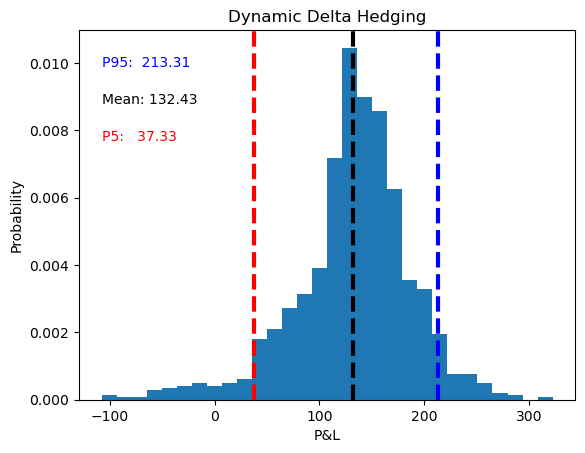

In [13]:
x = Dynamic_Hedging_Results.loc['Total Cashflow',]
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Dynamic Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()

if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(
        x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')

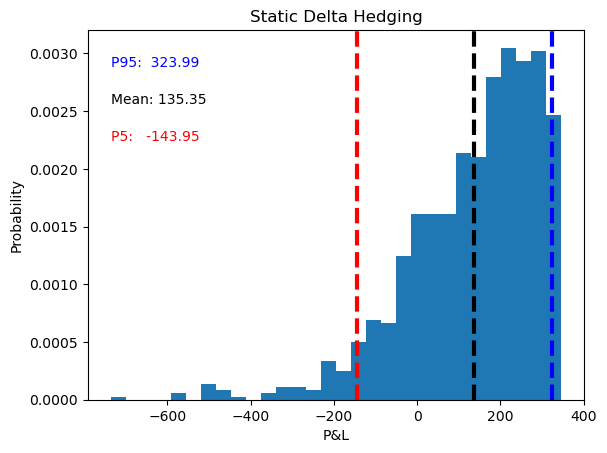

In [14]:
x = np.array(static_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('Static Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(
        x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')

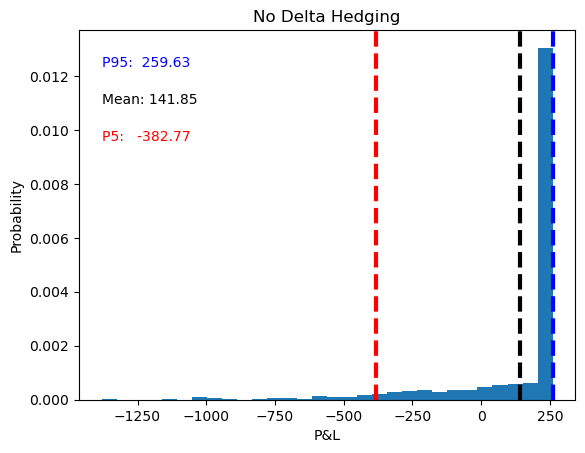

In [15]:
x = np.array(no_hedge)
plt.hist(x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('P&L');
x.mean(),np.percentile(x,5)
plt.title('No Delta Hedging')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,5), color='r', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(x,95), color='b', linestyle='dashed', linewidth=3)
min_ylim, max_ylim = plt.ylim()
if position == 's':
    plt.text(np.percentile(x,0), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,0), max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
    plt.text(np.percentile(x,0), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')
elif position == 'l':
    plt.text(np.percentile(x,99), max_ylim*0.9, 'P95:  {:.2f}'.format(
        np.percentile(x,95))).set_color('blue')
    plt.text(np.percentile(x,99), max_ylim*0.8, 'Mean: {:.2f}'.format(
        x.mean()))
    plt.text(np.percentile(x,99), max_ylim*0.7, 'P5:   {:.2f}'.format(
        np.percentile(x,5))).set_color('red')